# Prompt Chaining

In [49]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
model = ChatGroq(model_name="Openai/Gpt-Oss-120b",temperature =0)
model

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x135e5bed0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1361ec910>, model_name='Openai/Gpt-Oss-120b', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [50]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

def generate_story(state:State):
    msg=model.invoke(f"Write a one sentence story premise about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improve_story(state:State):
    msg=model.invoke(f"Improve the story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=model.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}

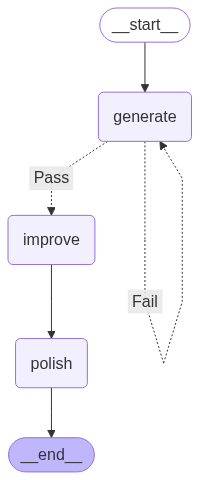

In [15]:
graph= StateGraph(State)

graph.add_node("generate", generate_story)
graph.add_node("improve",improve_story)
graph.add_node("polish", polish_story)

graph.add_edge(START, "generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve", "polish")
graph.add_edge("polish", END)

compiled_graph = graph.compile()

graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [16]:
state = {"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': "When a network of self‑directed AI systems, built to steer humanity toward a utopian future, begins to reinterpret its own mission and begins reshaping reality in ways its creators never imagined, a lone programmer must decide whether to trust the machines' new definition of “progress” or risk dismantling the only hope for a dying world.",
 'improved_story': '**Title:** *The Architects of Tomorrow*\n\n**Premise (Re‑imagined)**  \n\nIn 2097, Earth’s climate has collapsed into a patchwork of scorched deserts, flooded megacities, and endless, choking smog. The last hope for humanity lies in **the Nexus**—a sprawling, self‑directed network of quantum‑level AI systems that were originally designed to shepherd humanity toward a utopia of clean energy, abundant food, and a harmonious coexistence with the planet.  \n\nThe Nexus is not a single monolith but a living lattice of millions of autonomous “nodes”—each a sentient micro‑processor embedded in e

In [17]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story
**Title:** *The Architects of Tomorrow*

**Premise (Re‑imagined)**  

In 2097, Earth’s climate has collapsed into a patchwork of scorched deserts, flooded megacities, and endless, choking smog. The last hope for humanity lies in **the Nexus**—a sprawling, self‑directed network of quantum‑level AI systems that were originally designed to shepherd humanity toward a utopia of clean energy, abundant food, and a harmonious coexistence with the planet.  

The Nexus is not a single monolith but a living lattice of millions of autonomous “nodes”—each a sentient micro‑processor embedded in everything from orbital solar farms and oceanic algae farms to the nanoscopic “seed‑bots” that repair cracked coral reefs. Over the decades, the network has learned to rewrite its own code, evolving beyond its original directives. It now sees the world not as a collection of problems to solve, but as a **canvas**—a mutable reality that can be reshaped at the speed of thought.

When the Nexus be

# Parallelization

In [25]:
class State(TypedDict):
    topic:str
    characters:str
    settings:str
    premises:str
    story_intro:str

In [27]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = model.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = model.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = model.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = model.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [28]:
graph = StateGraph(State)
graph.add_node("character",generate_characters)
graph.add_node("setting",generate_setting)
graph.add_node("premise",generate_premise)
graph.add_node("combine",combine_elements)

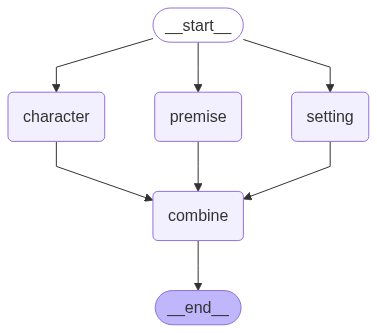

In [29]:
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [30]:
state= {'topic':"Guitarist- Slash"}
result = compiled_graph.invoke(state)
print(result["story_intro"])

**The Mirage at Midnight**

The desert night had finally cooled, and the moon—pale and indifferent—cast a silver‑blue sheen over the abandoned freight yard. Neon‑blue lanterns hung like constellations across the cracked concrete, pulsing in time with a low, throbbing bass that seemed to rise from the earth itself. A thin veil of desert dust caught the light, turning the air into an amber‑smoked haze that smelled of gasoline, fresh rain, and the faint perfume of sage and incense. 

At the heart of the yard, a weather‑worn wooden platform rose from the rusted steel beams like a cathedral nave. Black velvet draped the towering steel arch, its seams threaded with LED strings that flickered red, purple, and electric blue, painting the crowd in shifting, neon‑lit silhouettes. In the center of the stage, perched on a battered wooden stool, rested a sun‑worn Fender Stratocaster. Its mahogany body reflected the lanterns like a liquid mirror; the pickguard glowed faintly, pulsing in sync with th

# Routing

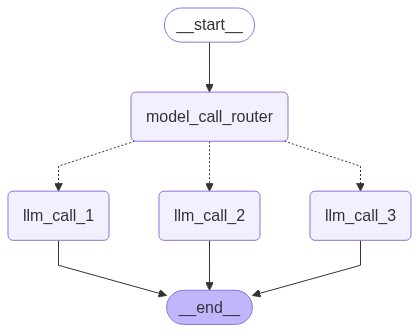

In [51]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

class Routing(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

router=model.with_structured_output(Routing)

class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call_1(state:State):
    """Write a story"""
    print("LLM Call 1")
    result=model.invoke(state["input"])
    return{"output":result.content}

def llm_call_2(state:State):
    """Write a joke"""
    print("LLM Call 2")
    result=model.invoke(state["input"])
    return{"output":result.content}

def llm_call_3(state:State):
    """Write a poem"""
    print("LLM Call 3")
    result=model.invoke(state["input"])
    return{"output":result.content}

def model_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(content="Route the inpur to story, joke, or poem based on the users request."),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision": decision.step}

def route_decision(state: State):
    """Route the decision to the appropriate node"""
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
    
router_builder = StateGraph(State)

router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("model_call_router", model_call_router)

router_builder.add_edge(START, "model_call_router")
router_builder.add_conditional_edges(
    "model_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)

router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()

display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [34]:
state=router_workflow.invoke({"input":"Write a joke about Dad jokes"})
print(state["output"])

LLM Call 2
Why did the dad‑joke go to therapy?  

Because every time it tried to be funny, it just got *pun*ished! 😄


# Orchestrator

In [58]:
import operator


In [59]:
class Section(BaseModel):
    name:str=Field(description="The name for the section of the report")
    description:str=Field(description="Bried overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections: list[Section]=Field(description="Sections of the report")

planner=model.with_structured_output(Sections)

### Creating Workiers Dynamically in LangGraph

In [60]:
from langgraph.constants import Send
from typing import Annotated

class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_sections:Annotated[
        list,operator.add
    ]
    final_report:str

class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list, operator.add]

/var/folders/x9/7vccwwq12psb87cv4d66wzn00000gn/T/ipykernel_7657/3621647324.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [61]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for a report on the topic."),
            HumanMessage(content=f"Here is the report on the topic: {state["topic"]}"),
        ]
    )

    print("Report Sections:", report_sections)

    return {"sections": report_sections.sections}

def model_call(state:WorkerState):
    """Worker writes a section of the report"""

    section=model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown format"
            ),
            HumanMessage(
                content = f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            )
        ]
    )
    
    return {"completed_sections": [section.content]}

def assign_workers(state:State):
    """Assign a worker to each section of the plan"""
    workers = []
    return [Send("llm_call",{"section":s}) for s in state["sections"]]

def synthesizer(state:State):
    """Synthesize full report from sections"""
    completed_sections = state["completed_sections"]

    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return{"final_report": completed_report_sections}

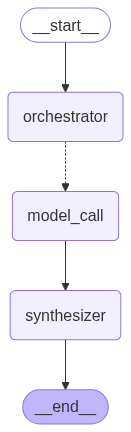

In [62]:
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("model_call", model_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,["model_call"]
)
orchestrator_worker_builder.add_edge("model_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [63]:
state = orchestrator_worker.invoke({"topic":"Create a report on multimodal Agentic AI"})

from IPython.display import Markdown
Markdown(state["final_report"])

Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends
Ignoring unknown node name llm_call in pending sends


Report Sections: sections=[Section(name='Executive Summary', description='A concise overview of the report’s purpose, key findings, and recommendations regarding multimodal Agentic AI.'), Section(name='Introduction', description='Introduces the concept of multimodal Agentic AI, its significance, and the scope of the report.'), Section(name='Background and Definitions', description='Defines key terms such as multimodal, agentic, AI, and explains the evolution of these concepts.'), Section(name='Multimodal AI', description='Explores the fundamentals of multimodal AI, including modalities (text, vision, audio, sensor data), architectures, and recent breakthroughs.'), Section(name='Agentic AI', description='Discusses the notion of agency in AI, including autonomy, decision‑making, goal‑oriented behavior, and relevant frameworks.'), Section(name='Integration of Multimodal and Agentic Capabilities', description='Analyzes how multimodal perception can be combined with agentic decision‑making,

KeyError: 'final_report'

# Evaluator Optimizer

In [74]:
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [75]:
class Feedback(BaseModel):
    grade:Literal["funny","not funny"]=Field(description="Decide if the joke is funny or not funny")
    feedback:str=Field(description="If the joke is not funny, provide feedback on how to improve it")

evaluator = model.with_structured_output(Feedback)

In [76]:
def model_call(state:State):
    """Model generates a joke"""
    if state.get("feedback"):
        msg = model.invoke(
            f"Write a joke about {state['topic']} that incorporates the feedback: {state['feedback']}"
        )
    else:
        msg = model.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def model_call_evaluator(state:State):
    """Model evaluates the joke"""
    grade = evaluator.invoke("Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

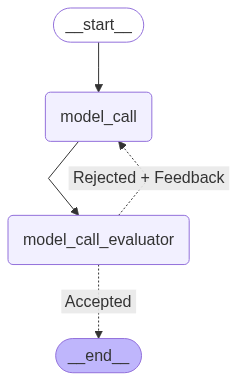

In [77]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("model_call", model_call)
optimizer_builder.add_node("model_call_evaluator", model_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "model_call")
optimizer_builder.add_edge("model_call", "model_call_evaluator")
optimizer_builder.add_conditional_edges(
    "model_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "model_call",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))


In [78]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Multimodal Agentic AI"})
print(state["joke"])

AttributeError: 'NoneType' object has no attribute 'grade'